<a href="https://colab.research.google.com/github/Prianka-Mukhopadhyay/pytorch-cifar10-classification/blob/main/cifar10_image_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transformations: convert images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize RGB channels
])

# Load training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# Load test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Example: get the first image and label from the training set
image_tensor, label = trainset[0]

print("Shape of image tensor:", image_tensor.shape)  # [3, 32, 32]
print("Label (as integer):", label)                  # e.g., 6
print("Label (as class name):", classes[label])     # e.g., 'frog'


100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Shape of image tensor: torch.Size([3, 32, 32])
Label (as integer): 6
Label (as class name): frog


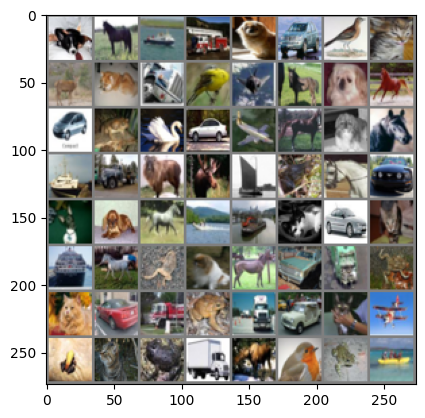

dog horse ship truck dog car bird cat


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize (reverse of Normalize)
    npimg = img.numpy()     # convert tensor to NumPy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # convert [C,H,W] to [H,W,C]
    plt.show()

# Get one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First convolution: input channels=3 (RGB), output channels=6, kernel size=5
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Second convolution: input channels=6, output channels=16, kernel size=5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 is the size after pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 output classes for CIFAR-10

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [5]:
# Train the network
num_epochs = 5  # you can increase this for better accuracy

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Print statistics every 200 mini-batches
        running_loss += loss.item()
        if i % 200 == 199:  # print every 200 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}")
            running_loss = 0.0

print("Finished Training")



[1, 200] loss: 2.303
[1, 400] loss: 2.300
[1, 600] loss: 2.297
[2, 200] loss: 2.280
[2, 400] loss: 2.231
[2, 600] loss: 2.112
[3, 200] loss: 1.914
[3, 400] loss: 1.849
[3, 600] loss: 1.794
[4, 200] loss: 1.707
[4, 400] loss: 1.692
[4, 600] loss: 1.637
[5, 200] loss: 1.573
[5, 400] loss: 1.576
[5, 600] loss: 1.531
Finished Training


In [6]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


In [7]:
correct = 0
total = 0

# Disable gradient calculation for evaluation (faster, saves memory)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)  # highest score = predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the 10000 test images: {100 * correct / total:.2f}%')


Accuracy on the 10000 test images: 45.91%


In [8]:
# ==========================================
# 📌 Step 3: Loss Function & Optimizer
# ==========================================
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# Changed from SGD to Adam for faster, adaptive learning
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [9]:
# ==========================================
# 📌 Step 4: Training the Network (20 Epochs)
# ==========================================
num_epochs = 20  # increased from 5 to 20 for better accuracy

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print(f"[{epoch+1}, {i+1}] loss: {running_loss/200:.3f}")
            running_loss = 0.0

print("Finished Training")


[1, 200] loss: 1.549
[1, 400] loss: 1.498
[1, 600] loss: 1.424
[2, 200] loss: 1.330
[2, 400] loss: 1.310
[2, 600] loss: 1.266
[3, 200] loss: 1.210
[3, 400] loss: 1.201
[3, 600] loss: 1.170
[4, 200] loss: 1.120
[4, 400] loss: 1.111
[4, 600] loss: 1.110
[5, 200] loss: 1.072
[5, 400] loss: 1.052
[5, 600] loss: 1.050
[6, 200] loss: 0.996
[6, 400] loss: 1.003
[6, 600] loss: 1.007
[7, 200] loss: 0.932
[7, 400] loss: 0.962
[7, 600] loss: 0.961
[8, 200] loss: 0.896
[8, 400] loss: 0.903
[8, 600] loss: 0.910
[9, 200] loss: 0.855
[9, 400] loss: 0.870
[9, 600] loss: 0.889
[10, 200] loss: 0.824
[10, 400] loss: 0.830
[10, 600] loss: 0.838
[11, 200] loss: 0.788
[11, 400] loss: 0.801
[11, 600] loss: 0.812
[12, 200] loss: 0.752
[12, 400] loss: 0.770
[12, 600] loss: 0.779
[13, 200] loss: 0.722
[13, 400] loss: 0.728
[13, 600] loss: 0.746
[14, 200] loss: 0.686
[14, 400] loss: 0.727
[14, 600] loss: 0.718
[15, 200] loss: 0.659
[15, 400] loss: 0.696
[15, 600] loss: 0.694
[16, 200] loss: 0.634
[16, 400] loss:

In [10]:
# ==========================================
# 📌 Step 5: Evaluation on Test Set
# ==========================================
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the 10000 test images: {100 * correct / total:.2f}%')


Accuracy on the 10000 test images: 63.68%


In [11]:
# ==========================================
# 📌 Step 6: Save the Model
# ==========================================
torch.save(net.state_dict(), 'cifar_net.pth')
print("Model saved as cifar_net.pth")


Model saved as cifar_net.pth


GroundTruth: cat ship ship plane
Predicted:    cat ship ship plane


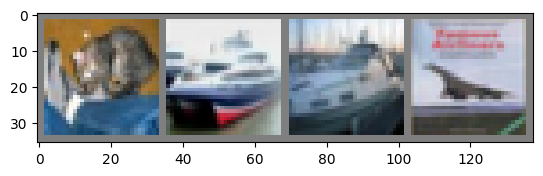

In [12]:
# ==========================================
# 📌 Step 7: Visualize Predictions on Test Images
# ==========================================
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and show image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Print ground truth
print('GroundTruth:', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

# Predict
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))

# Show images
imshow(torchvision.utils.make_grid(images[:4]))


Plot Training Loss Curve

In [13]:
loss_history = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 200 == 199:
            avg_loss = running_loss / 200
            loss_history.append(avg_loss)
            print(f"[{epoch+1}, {i+1}] loss: {avg_loss:.3f}")
            running_loss = 0.0

print("Finished Training")


[1, 200] loss: 0.531
[1, 400] loss: 0.550
[1, 600] loss: 0.593
[2, 200] loss: 0.516
[2, 400] loss: 0.551
[2, 600] loss: 0.579
[3, 200] loss: 0.491
[3, 400] loss: 0.529
[3, 600] loss: 0.529
[4, 200] loss: 0.478
[4, 400] loss: 0.502
[4, 600] loss: 0.542
[5, 200] loss: 0.459
[5, 400] loss: 0.486
[5, 600] loss: 0.527
[6, 200] loss: 0.447
[6, 400] loss: 0.467
[6, 600] loss: 0.502
[7, 200] loss: 0.430
[7, 400] loss: 0.462
[7, 600] loss: 0.490
[8, 200] loss: 0.413
[8, 400] loss: 0.446
[8, 600] loss: 0.478
[9, 200] loss: 0.391
[9, 400] loss: 0.438
[9, 600] loss: 0.456
[10, 200] loss: 0.380
[10, 400] loss: 0.435
[10, 600] loss: 0.428
[11, 200] loss: 0.377
[11, 400] loss: 0.402
[11, 600] loss: 0.444
[12, 200] loss: 0.374
[12, 400] loss: 0.389
[12, 600] loss: 0.436
[13, 200] loss: 0.362
[13, 400] loss: 0.381
[13, 600] loss: 0.412
[14, 200] loss: 0.343
[14, 400] loss: 0.372
[14, 600] loss: 0.414
[15, 200] loss: 0.347
[15, 400] loss: 0.363
[15, 600] loss: 0.388
[16, 200] loss: 0.320
[16, 400] loss:

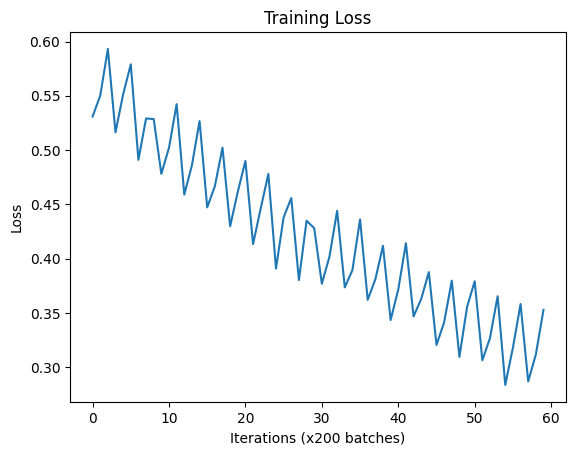

In [14]:
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Iterations (x200 batches)")
plt.ylabel("Loss")
plt.show()
